# Animals-10 Veri Seti ile CNN Çalışması
# Proje Yapısı
- Kütüphanelerin eklenmesi
- Veri Ekleme
- Veri Görselleştirme
- Data Augmentation + preprocessing
- Callback
- Derleme
- Training
- Evaulate

# Veri Seti Tanıma:
- 10  farklı hayvanımız var.
- her görüntü rgb olmak üzere 3 kanallıdır
- her görsel farklı boyutlarda ama bu bizim için sorun değil input katmanına ne girersek o boyutu hepsi resize olacak

# 1-) Kütüphanelerin Eklenmesi

In [2]:
from PIL import Image
import os


from tensorflow.data import AUTOTUNE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import(
    # Feature Extraction Katmanları
    Conv2D,
    MaxPooling2D,

    # Classification Katmanı
    Flatten, # çok boyutluyu tek vektöre çevirme
    Dropout, # overfitting engelleme
    Dense, # Fully Connected Layer
)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import(
    EarlyStopping, # overfit için erken durdurma
    ModelCheckpoint, # MOdel kaydetme
    ReduceLROnPlateau, # Öğrenme oranı azaltma

)

import tensorflow as tf
import matplotlib.pyplot as plt



# 2-) Veri Setini Ekleme





In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!cp "/content/drive/MyDrive/archive.zip" .


In [5]:
!unzip archive.zip -d animals10


Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: animals10/Animals-10/spider/spider (2373).jpeg  
  inflating: animals10/Animals-10/spider/spider (2374).jpeg  
  inflating: animals10/Animals-10/spider/spider (2375).jpeg  
  inflating: animals10/Animals-10/spider/spider (2376).jpeg  
  inflating: animals10/Animals-10/spider/spider (2377).jpeg  
  inflating: animals10/Animals-10/spider/spider (2378).jpeg  
  inflating: animals10/Animals-10/spider/spider (2379).jpeg  
  inflating: animals10/Animals-10/spider/spider (238).jpeg  
  inflating: animals10/Animals-10/spider/spider (238).jpg  
  inflating: animals10/Animals-10/spider/spider (2380).jpeg  
  inflating: animals10/Animals-10/spider/spider (2381).jpeg  
  inflating: animals10/Animals-10/spider/spider (2382).jpeg  
  inflating: animals10/Animals-10/spider/spider (2383).jpeg  
  inflating: animals10/Animals-10/spider/spider (2384).jpeg  
  inflating: animals10/Animals-10/spider/spider (2385).jpeg  
  inflating: animals10/Ani

# 3-) Veri Seti Bilgi

In [6]:
import os

data_dir = "animals10/Animals-10"

classes = os.listdir(data_dir)
print("Sınıflar:", classes)
print("Sınıf sayısı:", len(classes))


Sınıflar: ['cat', 'elephant', 'dog', 'horse', 'butterfly', 'sheep', 'cow', 'chicken', 'spider', 'squirrel']
Sınıf sayısı: 10


Görsel yolu: animals10/Animals-10/cat/cat (351).jpg
Boyut: (640, 426)


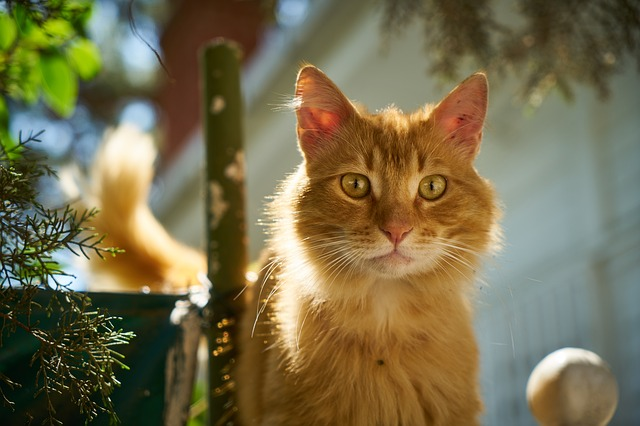

In [7]:


sample_path = data_dir + "/cat/" + os.listdir(data_dir + "/cat")[1]
img = Image.open(sample_path)
print("Görsel yolu:", sample_path)
print("Boyut:", img.size)
img


# 4-) Veri Setini Yükleme

In [8]:
import pathlib
from sklearn.model_selection import train_test_split

def load_local_dataset(root_dir):

    root = pathlib.Path(root_dir)
    class_names = sorted([d.name for d in root.iterdir() if d.is_dir()])

    image_paths = []
    labels = []

    for label, cname in enumerate(class_names):
        folder = root / cname
        for img_path in folder.glob("*"):
            image_paths.append(str(img_path))
            labels.append(label)

    # %80 train, %20 validation
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        image_paths, labels, test_size=0.2, shuffle=True, random_state=42
    )

    return (train_paths, train_labels), (val_paths, val_labels), class_names


In [9]:
(train_paths, train_labels), (val_paths, val_labels), class_names = load_local_dataset(
    "animals10/Animals-10"
)

print("Train örnek sayısı:", len(train_paths))
print("Validation örnek sayısı:", len(val_paths))
print("Sınıflar:", class_names)

print("1. Train örneği path:", train_paths[0])
print("1. Train örneği label:", train_labels[0])



Train örnek sayısı: 20943
Validation örnek sayısı: 5236
Sınıflar: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
1. Train örneği path: animals10/Animals-10/chicken/chicken (968).jpeg
1. Train örneği label: 2


# 5-) Veri Görselleştirme

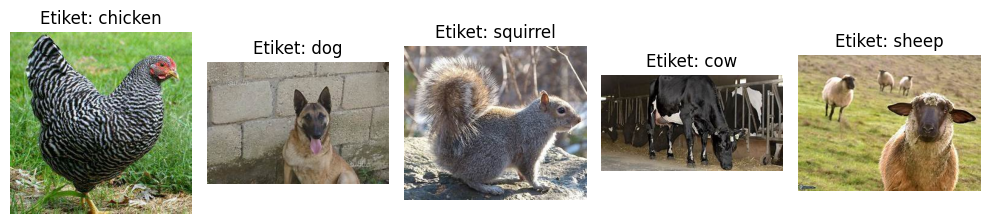

In [10]:
import matplotlib.pyplot as plt
from PIL import Image

fig = plt.figure(figsize=(10,5))

for i in range(5):
    img_path = train_paths[i]    # görüntü yolu
    label = train_labels[i]      # label integer

    img = Image.open(img_path)

    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(img)
    ax.set_title(f"Etiket: {class_names[label]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


# 6-) Data Augmentation + Preprocessor

In [11]:
import tensorflow as tf
import pathlib
from sklearn.model_selection import train_test_split

# ================================
# 1) DATASETİ YÜKLE
# ================================

def load_local_dataset(root_dir):

    root = pathlib.Path(root_dir)
    class_names = sorted([d.name for d in root.iterdir() if d.is_dir()])

    image_paths = []
    labels = []

    for label, cname in enumerate(class_names):
        folder = root / cname
        for img_path in folder.glob("*"):
            image_paths.append(str(img_path))   # string path
            labels.append(label)

    # %80 TRAIN / %20 VALIDATION
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        image_paths, labels, test_size=0.2, shuffle=True, random_state=42
    )

    return (train_paths, train_labels), (val_paths, val_labels), class_names



# ================================
# 2) DATASETİ YÜKLE (senin klasörün)
# ================================

(train_paths, train_labels), (val_paths, val_labels), class_names = load_local_dataset(
    "animals10/Animals-10"
)

print("Train:", len(train_paths))
print("Validation:", len(val_paths))
print("Sınıflar:", class_names)



# ================================
# 3) PREPROCESS FONKSİYONLARI
# ================================

IMG_SIZE = (220, 220)
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_train(img, label):

    # PATH → IMAGE
    img = tf.io.read_file(img)
    img = tf.io.decode_jpeg(img, channels=3)

    # resize
    img = tf.image.resize(img, IMG_SIZE)

    # augmentations
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.2)
    img = tf.image.random_contrast(img, 0.8, 1.2)

    # random crop
    img = tf.image.random_crop(img, size=(200, 200, 3))

    # tekrar hedef boyuta getir
    img = tf.image.resize(img, IMG_SIZE)

    # normalize
    img = tf.cast(img, tf.float32) / 255.0

    label = tf.cast(label, tf.int32)
    return img, label


def preprocess_validation(img, label):

    # PATH → IMAGE
    img = tf.io.read_file(img)
    img = tf.io.decode_jpeg(img, channels=3)

    # sadece resize + normalize
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    label = tf.cast(label, tf.int32)
    return img, label



# ================================
# 4) TF.DATA PIPELINE
# ================================

ds_train = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
ds_validation = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

ds_train = (
    ds_train
    .map(preprocess_train, num_parallel_calls=AUTOTUNE)
    .shuffle(1000)
    .batch(32)
    .prefetch(AUTOTUNE)
)

ds_validation = (
    ds_validation
    .map(preprocess_validation, num_parallel_calls=AUTOTUNE)
    .batch(32)
    .prefetch(AUTOTUNE)
)


Train: 20943
Validation: 5236
Sınıflar: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


# 7-) Model Oluşturma

In [12]:
model = Sequential([

  # Feayre Extraction Layers
  Conv2D(32, (3, 3), activation='relu',input_shape=(220,220,3)),
  MaxPooling2D(2,2),
  Conv2D(64,(3,3),activation="relu"),
  MaxPooling2D(2,2),
  Conv2D(128,(3,3),activation="relu"),
  MaxPooling2D(2,2),

  #Classification Layers
  Flatten(),
  Dropout(0.5),
  Dense(128,activation="relu"),
  Dense(10,activation="softmax")
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# 8-) CallBacks


In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks2 = [

    # Eğer val loss 3 epoch boyunca iyileşmez ise eğitimi durdur ve en iyi ağırlıkları yükle
    EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    ),

    # val loss 2 epeoch boyunca iyileşmez ise learning rate 0.2 çarpanı ile azalt
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=2,
        verbose=1,
        min_lr=1e-8
    ),

    # Her epoch sonunda eğer model daha iyi ise Modeli kaydetme
    ModelCheckpoint(
        "best_model.h5",
        save_best_only=True
    )
]


# 9-) Model Derleme(Compile)

In [14]:
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = "sparse_categorical_crossentropy",
    metrics =["accuracy"]

)

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 218, 218, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 107, 107, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,240,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,334,666 (39.42 MB)

 Trainable params: 10,334,666 (39.42 MB)

 Non-trainable params: 0 (0.00 B)

None


# 10-)Model Training

In [15]:
history = model.fit(
    ds_train,
    validation_data = ds_validation,
    epochs=15,
    callbacks=callbacks2,
    verbose =1 # Her adımda eğitim ilerlemesini göster




)

Epoch 1/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.2891 - loss: 2.0322

655/655 ━━━━━━━━━━━━━━━━━━━━ 79s 106ms/step - accuracy: 0.2893 - loss: 2.0318 - val_accuracy: 0.4885 - val_loss: 1.5045 - learning_rate: 0.0010
Epoch 2/15
654/655 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5035 - loss: 1.4408

655/655 ━━━━━━━━━━━━━━━━━━━━ 59s 81ms/step - accuracy: 0.5035 - loss: 1.4407 - val_accuracy: 0.5552 - val_loss: 1.3235 - learning_rate: 0.0010
Epoch 3/15
654/655 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5702 - loss: 1.2614

655/655 ━━━━━━━━━━━━━━━━━━━━ 82s 81ms/step - accuracy: 0.5703 - loss: 1.2613 - val_accuracy: 0.5837 - val_loss: 1.2337 - learning_rate: 0.0010
Epoch 4/15
654/655 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6049 - loss: 1.1603

655/655 ━━━━━━━━━━━━━━━━━━━━ 55s 81ms/step - accuracy: 0.6050 - loss: 1.1601 - val_accuracy: 0.6612 - val_loss: 1.0182 - learning_rate: 0.0010
Epoch 5/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 52s 77ms/step - accuracy: 0.6406 - loss: 1.0522 - val_accuracy: 0.6492 - val_loss: 1.0345 - learning_rate: 0.0010
Epoch 6/15
654/655 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6645 - loss: 0.9890
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
655/655 ━━━━━━━━━━━━━━━━━━━━ 84s 79ms/step - accuracy: 0.6645 - loss: 0.9890 - val_accuracy: 0.6283 - val_loss: 1.1572 - learning_rate: 0.0010
Epoch 7/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7037 - loss: 0.8790

655/655 ━━━━━━━━━━━━━━━━━━━━ 52s 77ms/step - accuracy: 0.7038 - loss: 0.8790 - val_accuracy: 0.6988 - val_loss: 0.9070 - learning_rate: 2.0000e-04
Epoch 8/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 51s 76ms/step - accuracy: 0.7159 - loss: 0.8247 - val_accuracy: 0.6971 - val_loss: 0.9081 - learning_rate: 2.0000e-04
Epoch 9/15
654/655 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7240 - loss: 0.8090
Epoch 9: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
655/655 ━━━━━━━━━━━━━━━━━━━━ 49s 72ms/step - accuracy: 0.7240 - loss: 0.8090 - val_accuracy: 0.6986 - val_loss: 0.9127 - learning_rate: 2.0000e-04
Epoch 10/15
654/655 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7390 - loss: 0.7732

655/655 ━━━━━━━━━━━━━━━━━━━━ 51s 76ms/step - accuracy: 0.7390 - loss: 0.7731 - val_accuracy: 0.7099 - val_loss: 0.8830 - learning_rate: 4.0000e-05
Epoch 11/15
654/655 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7360 - loss: 0.7726

655/655 ━━━━━━━━━━━━━━━━━━━━ 51s 76ms/step - accuracy: 0.7360 - loss: 0.7725 - val_accuracy: 0.7116 - val_loss: 0.8798 - learning_rate: 4.0000e-05
Epoch 12/15
654/655 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7393 - loss: 0.7599

655/655 ━━━━━━━━━━━━━━━━━━━━ 50s 74ms/step - accuracy: 0.7394 - loss: 0.7598 - val_accuracy: 0.7137 - val_loss: 0.8735 - learning_rate: 4.0000e-05
Epoch 13/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 83s 75ms/step - accuracy: 0.7435 - loss: 0.7592 - val_accuracy: 0.7070 - val_loss: 0.8927 - learning_rate: 4.0000e-05
Epoch 14/15
654/655 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7423 - loss: 0.7482
Epoch 14: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
655/655 ━━━━━━━━━━━━━━━━━━━━ 54s 80ms/step - accuracy: 0.7423 - loss: 0.7482 - val_accuracy: 0.7024 - val_loss: 0.8953 - learning_rate: 4.0000e-05
Epoch 15/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 78s 75ms/step - accuracy: 0.7490 - loss: 0.7445 - val_accuracy: 0.7091 - val_loss: 0.8815 - learning_rate: 8.0000e-06


# 11-) Doğruluk Grafiği

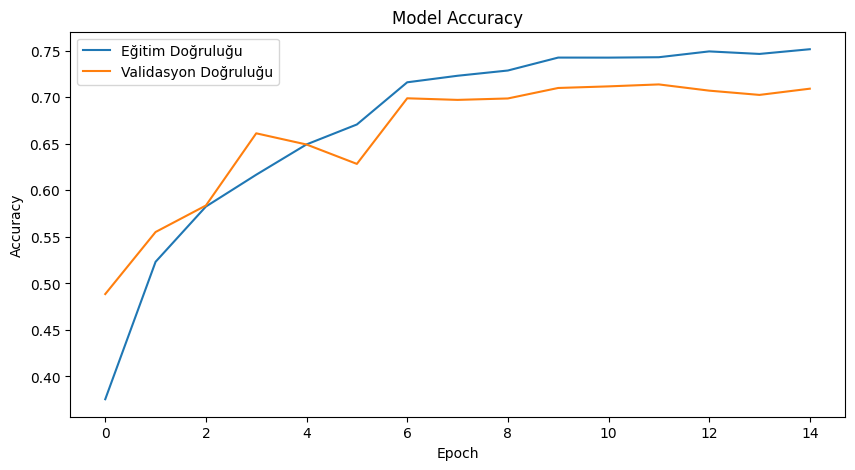

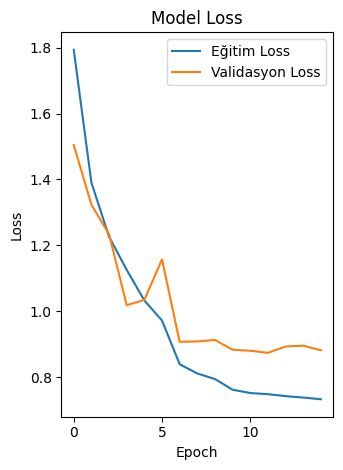

In [16]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'],label="Eğitim Doğruluğu")
plt.plot(history.history["val_accuracy"],label = "Validasyon Doğruluğu")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.show()

#loss plot

plt.subplot(1,2,2)
plt.plot(history.history["loss"],label="Eğitim Loss")
plt.plot(history.history["val_loss"],label="Validasyon Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")

plt.legend()
plt.tight_layout()
plt.show()

In [17]:
val_loss, val_acc = model.evaluate(ds_validation)
print(f"Validation Accuracy: {val_acc*100:.2f}%")


164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.7120 - loss: 0.8857
Validation Accuracy: 71.37%


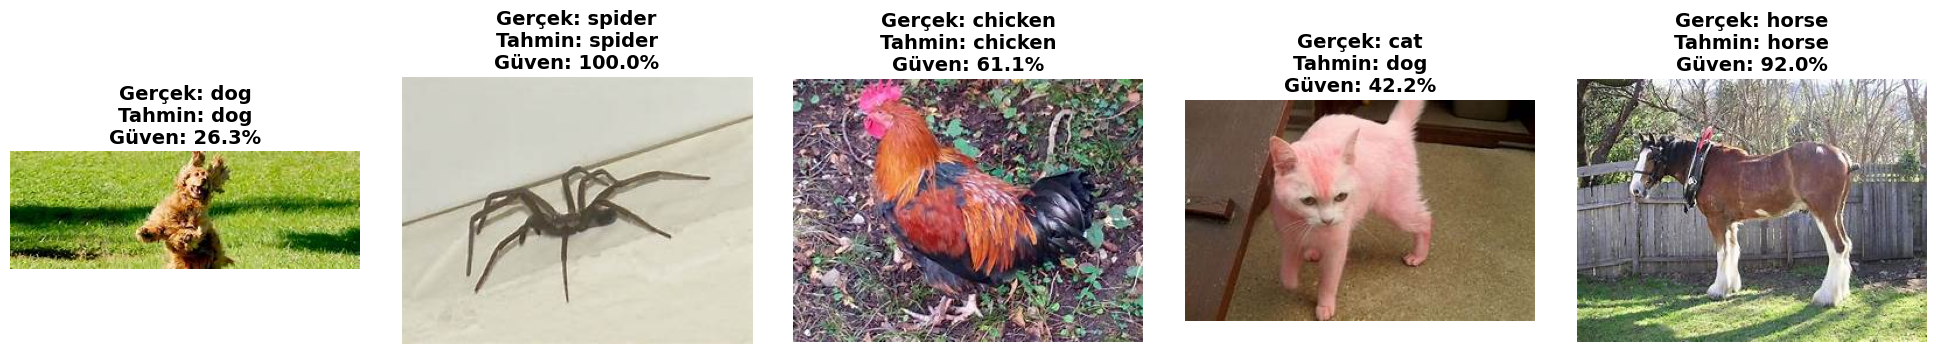

In [24]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random

IMG_SIZE = (220, 220)

def predict_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, 0)

    pred = model.predict(img, verbose=0)[0]
    pred_class = tf.argmax(pred).numpy()
    confidence = pred[pred_class]

    return pred_class, confidence


# --- 5 GÖRSEL GÖSTER ---
plt.figure(figsize=(20, 8))   # daha büyük çizim alanı

for i in range(5):
    idx = random.randint(0, len(val_paths)-1)
    img_path = val_paths[idx]
    true_label = val_labels[idx]

    pred_label, conf = predict_image(img_path)

    # subplot 1x5
    plt.subplot(1, 5, i + 1)

    # image
    plt.imshow(plt.imread(img_path))
    plt.axis("off")

    # title
    plt.title(
        f"Gerçek: {class_names[true_label]}\n"
        f"Tahmin: {class_names[pred_label]}\n"
        f"Güven: {conf*100:.1f}%",
        fontsize=14,
        fontweight="bold"
    )

plt.tight_layout(pad=3.0)   # görseller arası boşluk
plt.show()
